# LSTM SMILES 예제

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [4]:
sentence = 'c1cc(ccc1C(F)(F)F)S(=O)(=O)N2CCN(C[C@@H]2C(=O)NCc3ccc(c(c3)F)OC(F)(F)F)c4nc5c(s4)cnc(n5)C6CC6'
x = sentence[:]
y = sentence[:]

char_set = list(set(sentence))
input_size = len(char_set)
hidden_size = len(char_set)

index2char = {i:c for i, c in enumerate(char_set)}
char2index = {c:i for i, c in enumerate(char_set)}

In [5]:
print(x)
print(y)

c1cc(ccc1C(F)(F)F)S(=O)(=O)N2CCN(C[C@@H]2C(=O)NCc3ccc(c(c3)F)OC(F)(F)F)c4nc5c(s4)cnc(n5)C6CC6
c1cc(ccc1C(F)(F)F)S(=O)(=O)N2CCN(C[C@@H]2C(=O)NCc3ccc(c(c3)F)OC(F)(F)F)c4nc5c(s4)cnc(n5)C6CC6


In [6]:
print(char2index)

{')': 0, 'O': 1, 'C': 2, '3': 3, '1': 4, '5': 5, 'n': 6, '4': 7, 'H': 8, 'N': 9, '=': 10, '@': 11, ']': 12, '(': 13, '2': 14, '6': 15, 'c': 16, 's': 17, 'F': 18, 'S': 19, '[': 20}


In [7]:
print(char_set)
print(input_size)
print(hidden_size)

[')', 'O', 'C', '3', '1', '5', 'n', '4', 'H', 'N', '=', '@', ']', '(', '2', '6', 'c', 's', 'F', 'S', '[']
21
21


In [8]:
one_hot = []
for i, tkn in enumerate(x):
    one_hot.append(np.eye(len(char_set), dtype='int')[char2index[tkn]])
    
x_train = torch.Tensor(one_hot)
x_train = x_train.view(1, len(x), -1)

In [9]:
print(x_train)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [10]:
# y label
y_data = [char2index[c] for c in y]
y_data = torch.Tensor(y_data)

## Build a model

In [11]:
class RNN(nn.Module):
    
    # (batch_size, n, )
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 4,
            batch_first = True,
            bidirectional = True
        )
        
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Linear(input_size*2, hidden_size),
        )
        
    def forward(self, x):
        y,_ = self.rnn(x)
        y = self.layers(y)
        return y

model = RNN(input_size, hidden_size)
model

RNN(
  (rnn): LSTM(21, 21, num_layers=4, batch_first=True, bidirectional=True)
  (layers): Sequential(
    (0): ReLU()
    (1): Linear(in_features=42, out_features=21, bias=True)
  )
)

## loss & optimizer setting

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# training

In [13]:
%%time
epoch = 4000
loss_values = []
for i in range(epoch):
    model.train()
    outputs = model(x_train)
    loss = criterion(outputs.view(-1, input_size), y_data.view(-1).long())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())
    
    if i%500 == 0:
        result = outputs.data.numpy().argmax(axis=2)
        result_str = ''.join([char_set[c] for c in np.squeeze(result)])
        print(i, "loss ", loss.item(), "\nprediction: ", result, "\ntrue Y: "
              , y_data, "\nprediction str: ", result_str, "\n")

0 loss  3.053136110305786 
prediction:  [[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
  20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
  20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
  20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]] 
true Y:  tensor([16.,  4., 16., 16., 13., 16., 16., 16.,  4.,  2., 13., 18.,  0., 13.,
        18.,  0., 18.,  0., 19., 13., 10.,  1.,  0., 13., 10.,  1.,  0.,  9.,
        14.,  2.,  2.,  9., 13.,  2., 20.,  2., 11., 11.,  8., 12., 14.,  2.,
        13., 10.,  1.,  0.,  9.,  2., 16.,  3., 16., 16., 16., 13., 16., 13.,
        16.,  3.,  0., 18.,  0.,  1.,  2., 13., 18.,  0., 13., 18.,  0., 18.,
         0., 16.,  7.,  6., 16.,  5., 16., 13., 17.,  7.,  0., 16.,  6., 16.,
        13.,  6.,  5.,  0.,  2., 15.,  2.,  2., 15.]) 
prediction str:  [[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[ 

500 loss  1.6650278568267

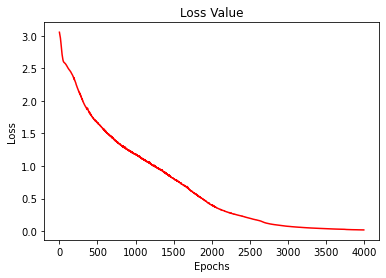

In [14]:
import matplotlib.pyplot as plt
plt.title('Loss Value')
plt.plot(np.array(loss_values), 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
path = './model.pth'
torch.save(model.state_dict(), path)

## model test

In [ ]:
model.eval()
x_test = 'C1N(c2nc3nc(C4CC4)ncc3s2)C[C@H](C(NCc2ccc(OC(F)(F)F)c(F)c2)=O)N(S(=O)(c2ccc(C(F)(F)F)cc2)=O)C1'
y_test = model(x_test)

-----------

참고문헌:  
http://cedartrees.co.kr/index.php/category/ai/pytorch-lstm/
https://github.com/BLarzalere/AI-De-Novo-Molecule-Design/blob/master/Data/latent_data.csv